### CASA0013: Introduction to Programming for Spatial Analysts







##### Student Number: 20111447






#### Title: Impact of Airbnb Listings on London Crime Distribution






word count: 1080 + 5 figures


## Executive Summary

This study examined the effect of different types of Airbnb housing on the distribution pattern of crime rates in Greater London by constructing a geographically weighted regression model. 

#### key findings

The article verified the superiority of GWR in this analysis by comparing the global and local models and found that the three housing types had a positive effect on the number of crimes in the area in the global model. 
  
In the local model, we found the density of private rooms to have a negative effect on the number of crimes in the east and north of London.
  
This study suggests that the government should make rules and improve the housing safety protection facilities of Airbnb, which can facilitate the construction of housing safety in Airbnb by including the platform in the scope of accountability. 
  
At the same time, the study identifies regional characteristics worthy of attention to inform future research.


# Reproducible Analysis

In this section we will do the regression analysis on the total sum of crime and different type of airbnb rooms.

Let's first import the package.

## Import package


In [1]:
import re
import os
import mgwr
import urllib
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import sklearn
import libpysal as lps

from shapely.geometry import Point
from fiona.crs import from_epsg
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib.colors import ListedColormap
from requests import get
from urllib.parse import urlparse

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

## Prepare for the dataset

There are mainly 4 datasets in this analysis:

1. London ward data = dfward
2. London crime data = dfcrime
3. London airbnb data = dfair
4. London dwelling list data = dfdwe

Let's load them one by one

In [2]:
# Load data ward
w_path = os.path.join('londonward.gpkg')
if not os.path.exists(w_path):
    dfward = gpd.read_file('https://github.com/Lingweiz1998/i2pfinalassessment/raw/main/londonward.gpkg?raw=true')
    dfward.to_file(w_path)
    print("Downloaded Ward gpkg file.")
else:
    dfward = gpd.read_file(w_path)

# Drop columns that do not need
dfward.drop(columns=['HECTARES', 'NONLD_AREA','DISTRICT','LAGSSCODE'], inplace=True)

# change the CRS
dfward = dfward.to_crs(epsg=27700)

dfward.head(3)

,NAME,GSS_CODE,geometry
0,Chessington South,E05000405,"MULTIPOLYGON (((516403.226 160201.683, 516408...."
1,Tolworth and Hook Rise,E05000414,"MULTIPOLYGON (((519554.642 164295.457, 519509...."
2,Berrylands,E05000401,"MULTIPOLYGON (((518109.062 167303.325, 518115...."


In [3]:
# Load data crime and only select needed columns
urlcrime = 'https://data.london.gov.uk/download/recorded_crime_summary/866c05de-c5cd-454b-8fe5-9e7c77ea2313/MPS%20Ward%20Level%20Crime%20%28most%20recent%2024%20months%29.csv'
colsC = ['MajorText', 'WardCode','201901', '201902', '201903', 
         '201904', '201905', '201906', '201907', '201908', 
         '201909', '201910', '201911', '201912']
dfcrime = pd.read_csv(urlcrime, low_memory=False,usecols=colsC)

# summarize the whole year count of the crime data
column_list = list(dfcrime)
column_list.remove("MajorText")
column_list.remove("WardCode")

dfcrime["sum of crime"] = dfcrime[column_list].sum(axis=1)
dfcrime1 = dfcrime[["MajorText","WardCode","sum of crime"]]

dfcrime2 = dfcrime1.groupby(['WardCode']).sum()
dfcrime2.head(3)

,sum of crime
WardCode,
E05000026,2886
E05000027,892
E05000028,1031


In [4]:
# load airbnb data and select necessary columns
urlairbnb = 'http://data.insideairbnb.com/united-kingdom/england/london/2019-12-09/data/listings.csv.gz'
colsA = ['latitude', 'longitude', 'room_type', 'availability_365']
dfair = pd.read_csv(urlairbnb, low_memory=False,usecols=colsA)

# clean the airbnb data
dfair.drop(dfair[((dfair.latitude.isna())|(dfair.longitude.isna()))].index, axis=0, inplace=True)

# change the data to spatial data frame
gdfair = gpd.GeoDataFrame(dfair, 
                          geometry=gpd.points_from_xy(dfair.longitude, dfair.latitude, crs='epsg:4326'))
gdfair = gdfair.to_crs('epsg:27700')

gdfair.head(3)

,latitude,longitude,room_type,availability_365,geometry
0,51.46225,-0.11732,Entire home/apt,0,POINT (530885.122 175377.940)
1,51.56802,-0.11121,Private room,357,POINT (531005.968 187150.843)
2,51.48796,-0.16898,Entire home/apt,193,POINT (527225.119 178145.995)


In [5]:
# load the dwelling dataset and only select the data in 2015
urldwe = 'https://data.london.gov.uk/download/dwellings-council-tax-band-wards/b1b9ea17-3fbb-4ecc-bf19-5246a3cf745b/dwellings-council-band-ward.csv'
colsD = ['New Code', 'Number of dwellings; 2015']
dfdwe = pd.read_csv(urldwe, low_memory=False,usecols=colsD)

dfdwe.head(3)

,New Code,Number of dwellings; 2015
0,E09000001,6680
1,E05000026,5060
2,E05000027,4140


## preparing the spatial data frame for the later GWR regression analysis

In [6]:
# count the airbnb listings by time in each wards, and merge all the dataset into one by ward code.

#sjoin the airbnb and ward data to count the rooms
wl = gpd.sjoin(gdfair,dfward,op='within').drop(columns=
    ['latitude','longitude','index_right'])
wlgc = wl.groupby(['room_type','GSS_CODE'])['availability_365'].agg(Count='count').reset_index() # ward listings grouped counts

# pivot longer
wlgc = wlgc.pivot(index='GSS_CODE', columns=['room_type'], values=['Count']).reset_index()
wlgc.columns = ['GSS_CODE','Entire home/apt','Hotel room','Private room','Shared room']
wlgc.drop(columns=['Hotel room'], inplace=True)

# merge the other 2 datasets in
wlg = pd.merge(wlgc,dfcrime2, left_on='GSS_CODE',right_on = 'WardCode',how = 'left')

wlg = pd.merge(wlg,dfdwe, left_on='GSS_CODE', right_on='New Code',how = 'left')
wlg.drop(columns=['New Code'], inplace=True)
wlg = wlg.fillna(0.01).set_index('GSS_CODE')

# create x indicator, which is [room count/ dwellings number]
wlg ['entire room density'] = wlg['Entire home/apt']/wlg['Number of dwellings; 2015']
wlg ['private room density'] = wlg['Private room']/wlg['Number of dwellings; 2015']
wlg ['shared room density'] = wlg['Shared room']/wlg['Number of dwellings; 2015']
wlg ['room density'] = (wlg['Entire home/apt']+wlg['Private room']+wlg['Shared room'])/wlg['Number of dwellings; 2015']

wlg.drop(columns=['Entire home/apt','Private room','Shared room','Number of dwellings; 2015'], inplace=True)
wlg.head(3)

,sum of crime,entire room density,private room density,shared room density,room density
GSS_CODE,,,,,
E05000026,2886.0,0.005731,0.007312,0.000395,0.013439
E05000027,892.0,0.000966,0.002415,0.000002,0.003384
E05000028,1031.0,0.001931,0.000965,0.000002,0.002898


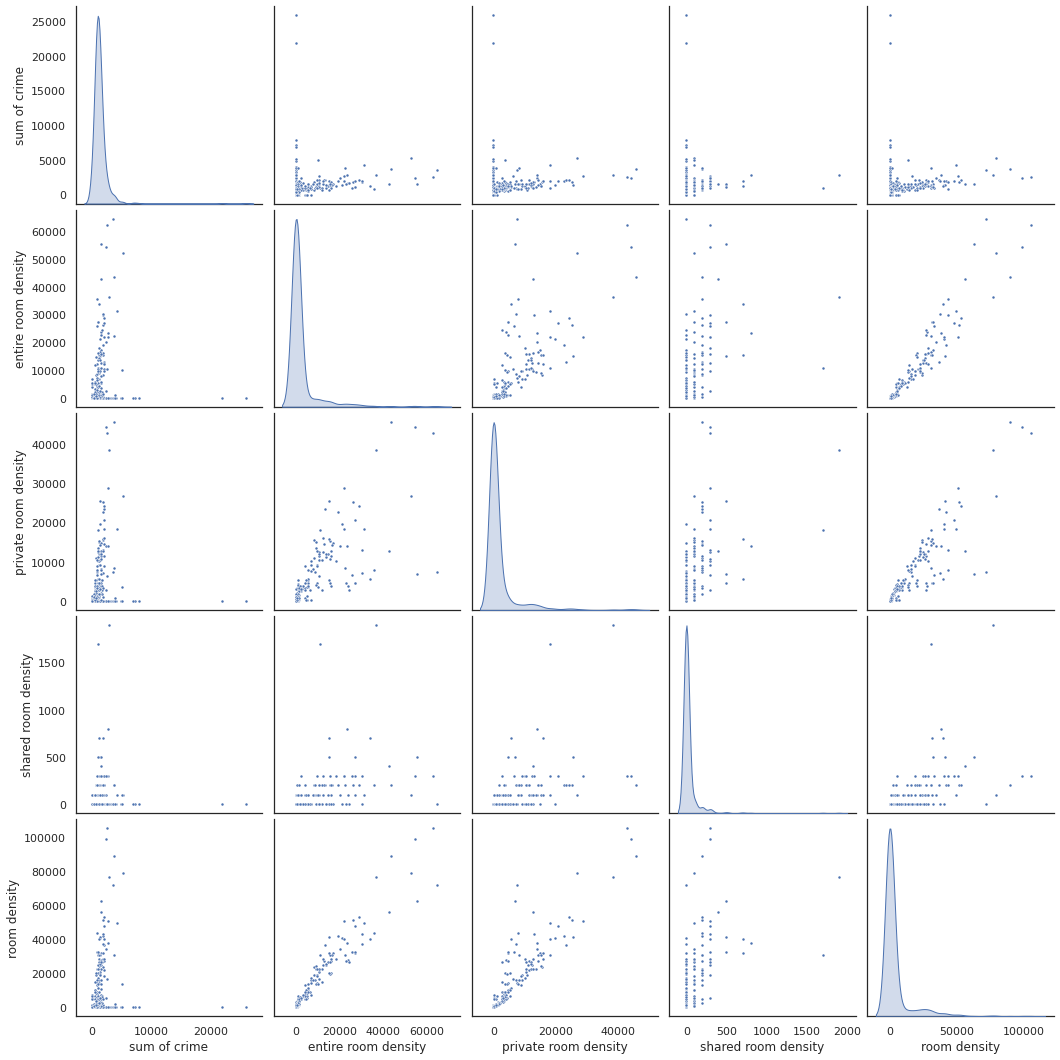

In [7]:
# check the data before normalization

sns.set(style="white")
sns.pairplot(wlg, markers=".", height=3, diag_kind='kde')

### use normalization to make better model!

In [8]:
for c in wlg.columns.values:
    wlg[c] = pts.fit_transform(wlg[c].values.reshape(-1,1))
    #wlg[c] = (wlg[c] - wlg[c].mean(axis=0)) / wlg[c].std(axis=0)
wlg.head(5)

,sum of crime,entire room density,private room density,shared room density,room density
GSS_CODE,,,,,
E05000026,1.401469,-0.600476,-0.589964,-0.567694,-0.604865
E05000027,-0.303490,-0.605211,-0.595043,-0.569020,-0.613716
E05000028,-0.133460,-0.604250,-0.596554,-0.569022,-0.614147
E05000029,-0.151114,-0.605929,-0.594737,-0.569020,-0.614094
E05000030,-0.347482,-0.605929,-0.594994,-0.569020,-0.614312


### Check their correlation after normalization

we can see that there may be some linear regression between them

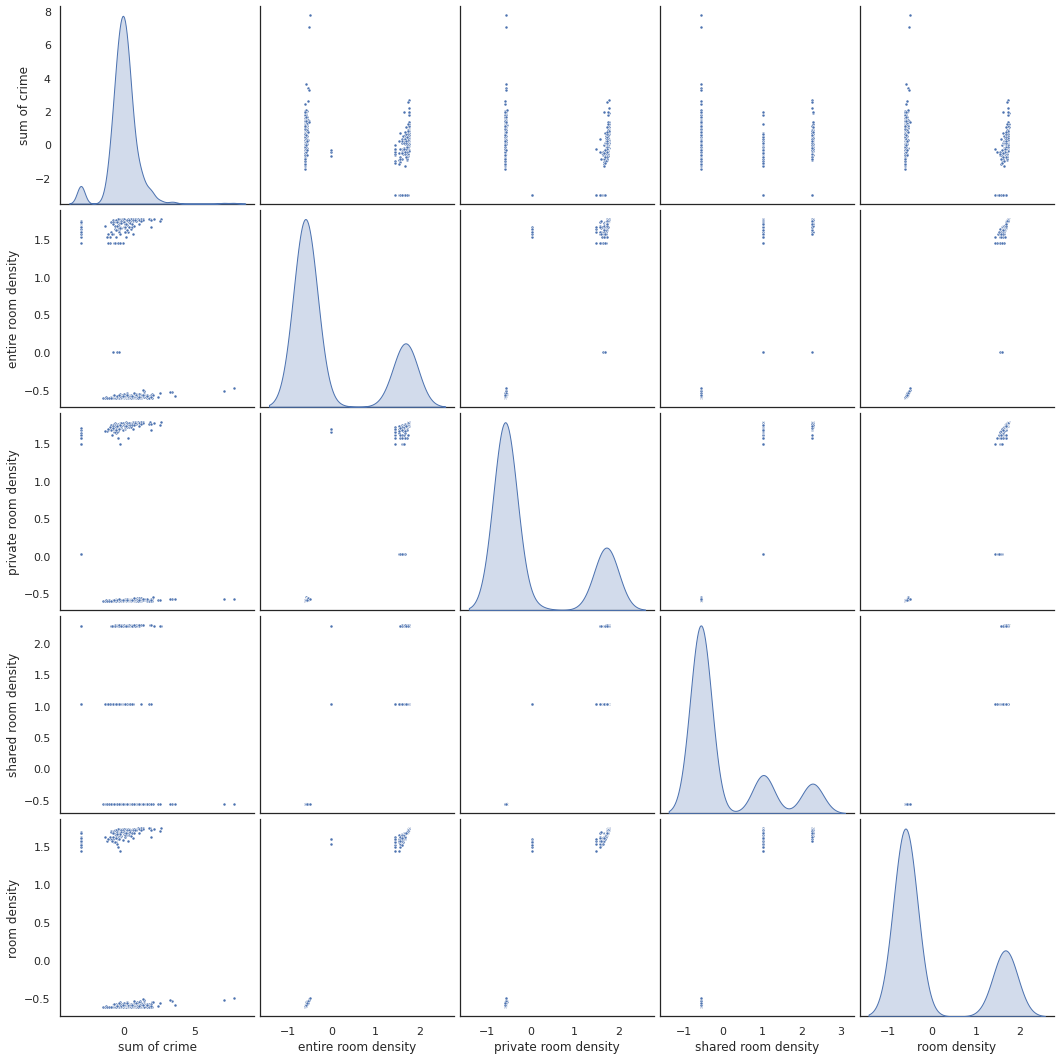

In [9]:
sns.set(style="white")
sns.pairplot(wlg, markers=".", height=3, diag_kind='kde')

In [10]:
## change the dataset to spatial object
wlg = pd.merge(wlg,dfward, on='GSS_CODE',how = 'left')
wlg = gpd.GeoDataFrame(wlg, crs="EPSG:27700", geometry='geometry').set_index('GSS_CODE')

## visualization

Before we go to the next step, we can check each variables by visualization to see their patterns.

<AxesSubplot:>

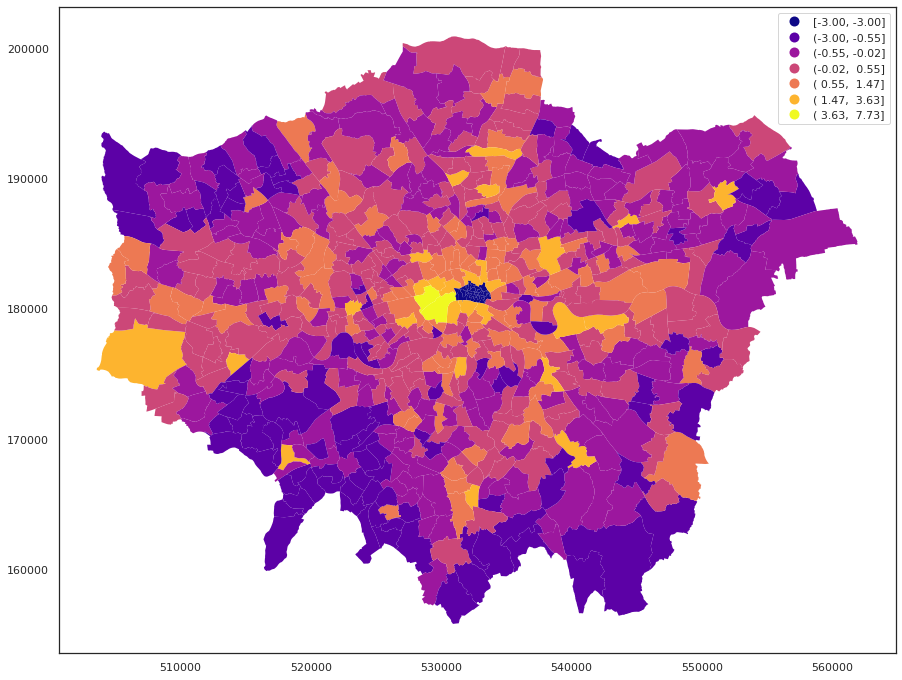

In [11]:
wlg.plot(column='sum of crime', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(15,15))

<AxesSubplot:>

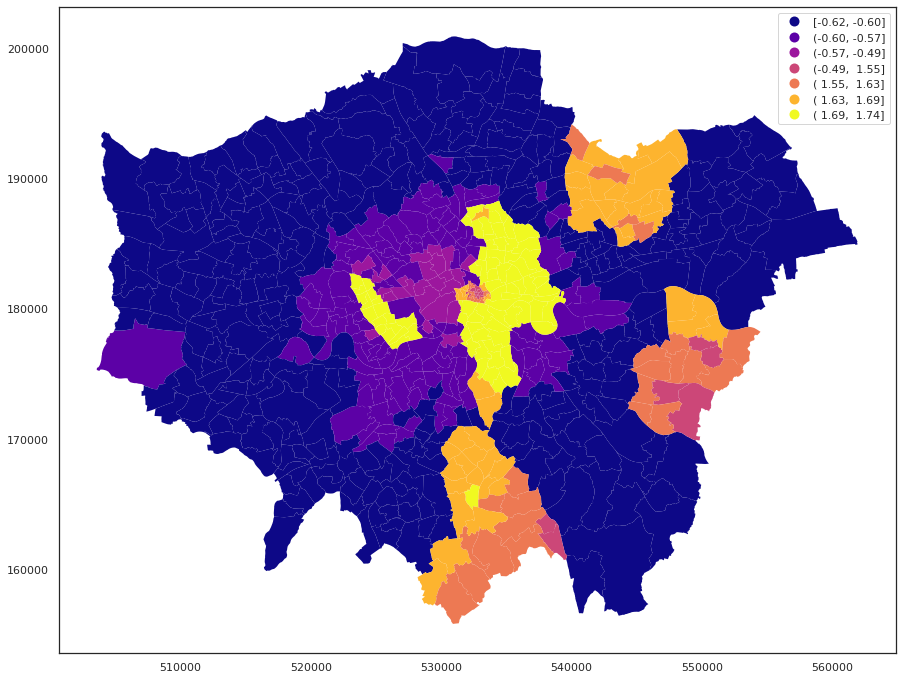

In [12]:
wlg.plot(column='room density', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(15,15))

## OLS and GWR

when we use pysal to do gwr analysis, we will also produce the OLS result for we to make comparison.

let's make the x and y dataset for the GWR!

In [ ]:
# data preparation

g_y = wlg['sum of crime'].values.reshape((-1,1))
g_X = wlg[['entire room density', 'private room density', 'shared room density']].values
u = wlg.centroid.x
v = wlg.centroid.x
g_coords = list(zip(u,v))

In [ ]:
## GWR processing!!

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)

gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
gwr_results.summary()

From here we will see some useful results, but for better explaination, we'd better do some visualization!

## Advanced plotting

We will now visualize the Local Estimate on the 95% confidience interval

In [ ]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = gwr_results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = gwr_results.filter_tvals(alpha=.1)
filtered_estimates99 = gwr_results.filter_tvals(alpha=.01)

In [ ]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(gwr_results.localR2)

# Create the new dataframe
df1=pd.DataFrame(wlg["NAME"])
df2 = df1.assign(entire_room_density=data_params[1],
                 private_room_density=data_params[2],
                 shared_room_density=data_params[3],
                 localR2=data_localR2[0])
df2.columns

In [ ]:
# Merge our shapefile with the model's results
dfward = dfward.merge(df2, on = 'GSS_CODE')
dfward.head()

In [ ]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(3,1,figsize=(30,12), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['figure 3: Entire room Estimate','figure 4: Private room Estimate','figure 5: Shared room Estimate']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T[1:4]):
    # We want to plot all the non-significant estimates in grey
    ct_temp = dfward.assign(toplot=filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
     
plt.show()

Looks Great! Now it's time for us to interprete this result and change it to some suggestion...

# Executive Briefing

## Introduction

　　The economic development of cities cannot be separated from the tourism economy, and the tourism industry has been the subject of much attention. Amongst other things, security issues related to the tourism industry are coming into focus, with many studies showing a positive correlation between areas with a high concentration of tourism and incidents of crime such as robbery, rape and theft (McPheters and Stronge, 1974; Baker and Stockton, 2014). Moreover, many documents document the occurrence of crime in hotel accommodation and find that burglary and vehicle theft are frequent crimes suffered by both hotel residents and owners (Jones and Mawby, 2005; Ho, Zhao and Brown, 2009; Ho, Zhao and Dooley, 2017 ). In addition to harming the victims themselves, increased crime rates can also impact local tourism ratings, reducing visitor numbers and leading to a reduction in revenue for tourism-related industries (Linden and Rockoff, 2008; Pope, 2008).

　　In recent years, Airbnb's crime problems, a tourism housing platform, have also attracted attention. Much of this discussion has rested on vehicles such as media reports and less professional analysis (Xu, Pennington-Gray and Kim, 2019). However, we have to acknowledge that the Airbnb model is very different from that of traditional hotels. There is a great need for targeted research on it. one of the most significant differences between Airbnb and hotels is that the accommodation is closer to the residential community, which may also increase crime rates in the community if the mobility and ethnic heterogeneity of the community increases (BURSIK, 1988; Sampson and Groves, 1989). Overall, Airbnb housing may affect both tourism-based crime and community-based crime. This result makes the gap in the field all the more troubling. Therefore, this article examines the impact of different types of Airbnb housing on the distribution patterns of crime rates in Greater London by constructing a geographically weighted regression model. The report verifies the superiority of GWR in this analysis by comparing the global model with the local model and unpacks the findings.

## Method and Result

　　This study's data was obtained from two websites: 1: London Datastore, the official London data site (Greater London Authority, no date) 2. Insider Airbnb, a database is containing Airbnb room types and locations (Inside Airbnb, 2020). In calculating the density of different room types in each area, we have used Susin's calculations (Susin, 2002). Her study uses housing/total housing measure in her research on low-cost housing. We believe that this approach is more reflective of the survey respondents' density than dividing the number of dwellings by the area, and removes any error caused by differences in the total number of houses in different wards. The number of crimes and the distribution of London Airbnb houses (all types, as the distribution patterns, are broadly similar across the three categories, with only differences in total density) across regions is shown in figure 1,2, where a colour closer to yellow indicates a higher degree of aggregation.

In [ ]:
wlg.plot(column='sum of crime', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(14,14))
plt.title('Figure 1: Sum of Crimes by wards',fontsize = 20)

In [ ]:
wlg.plot(column='room density', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(14,14))
plt.title('Figure 2: Room density by wards',fontsize = 20)

　　Besides, our study I designed to spatially explore the effects of crime distribution patterns and housing type densities. Therefore, using only OLS may produce errors due to ignoring spatial autocorrelation or the nature of spatial instability (Ward and Gleditsch, 2011). GWR is often used to explore the spatial relationship between crime phenomena and other socio-economic factors. Therefore, GWR is used in this paper as regression analysis (Cahill and Mulligan, 2007).

　　By comparing the regression models, we found that GWR's model was better than OLS's model, indicating that analysing the relationship between crime rates and Airbnb housing types from a spatial perspective leads to more meaningful conclusions. Second, globally, all three types of Airbnb rental housing significantly and positively affect the level of crime clustering, i.e. the higher the density of Airbnb housing in a place, the higher the number of crimes.

In [ ]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(3,1,figsize=(30,12), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['figure 3: Entire room Estimate','figure 4: Private room Estimate','figure 5: Shared room Estimate']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T[1:4]):
    # We want to plot all the non-significant estimates in grey
    ct_temp = dfward.assign(toplot=filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
     
plt.show()

　　Figures 3,4 and 5 show the strength of different housing density types on crime aggregation to varying wards within the local model's 95% confidence interval, Where the closer the colour is to yellow the more significant the positive effect on the number of offences, the closer it is to purple the exact opposite. We find that the Entire room's effect and shared room density on crime are more precise, with the most significant areas positively affecting the amount of crime. In contrast, private room density is positively correlated in almost half of the wards but negatively correlated in the other half. The negative correlation is more concentrated in central and northern Greater London.

## Findings and Suggestion

　　Compared to hotels, the extent to which Airbnb security measures are in place depends mainly on the choices made by individual hosts, as Airbnb currently only recommends that hosts install smoke alarms and carbon monoxide alarms, which is not mandatory (Airbnb, 2021). Other types of security devices (e.g. burglar locks, surveillance, etc.) are not prominently identified in Airbnb's security advice to hosts. It is difficult to determine whether the platform requires these aspects. Not only this but as London instituted a '90-day limit' policy in 2017 (Dudás et al., 2017), essentially relaxing the constraints on Airbnb rentals. As a result, more landlords are moving their properties into the short-term rental market, meaning that the number of Airbnb rentable properties in London has been rising in recent years. To prevent crime growth, the government should improve Airbnb's safety rules and hold the platform accountable for the substandard properties.

　　The pattern of impact of private rooms from a local perspective differs significantly from the other two. It has a negative effect on the number of crimes in central and northern London, contrary to the relevant studies mentioned in the previous section.

　　In summary, this study examined the effect of different types of Airbnb housing on the distribution pattern of crime rates in Greater London by constructing a geographically weighted regression model. The article verified the superiority of GWR in this analysis by comparing the global and local models and found that the three housing types had a positive effect on the number of crimes in the area in the global model. In the local model, we found the density of private rooms to have a negative effect on the number of crimes in the east and north of London. This study suggests that the government should make rules and improve the housing safety protection facilities of Airbnb, which can facilitate the construction of housing safety in Airbnb by including the platform in the scope of accountability. At the same time, the study identifies regional characteristics worthy of attention to inform future research.


## References

Airbnb (2021) I’m a host. Should I have a smoke and carbon monoxide (CO) detector installed? - Airbnb Help Centre.

Baker, D. and Stockton, S. (2014) ‘Tourism and Crime in America: A Preliminary Assessment of the Relationship between the Number of Tourists and Crime in two Major American Tourist Cities’, International Journal of Safety and Security in Tourism. Issue. Universidad de Palermo. Facultad de Ciencias Económicas, 5(5), pp. 1–25.

BURSIK, R. J. (1988) ‘SOCIAL DISORGANIZATION AND THEORIES OF CRIME AND DELINQUENCY: PROBLEMS AND PROSPECTS’, Criminology. John Wiley & Sons, Ltd, 26(4), pp. 519–552. doi: 10.1111/j.1745-9125.1988.tb00854.x.

Cahill, M. and Mulligan, G. (2007) ‘Using Geographically Weighted Regression to Explore Local Crime Patterns’, Social Science Computer Review. SAGE PublicationsSage CA: Los Angeles, CA, 25(2), pp. 174–193. doi: 10.1177/0894439307298925.

Dudás, G. et al. (2017) ‘A socio-economic analysis of Airbnb in New York City’, Regional Statistics. Hungarian Central Statistical Office, 7(1), pp. 135–151. doi: 10.15196/RS07108.

Greater London Authority (no date) London Datastore . Available at: https://data.london.gov.uk/ (Accessed: 13 January 2021).

Ho, T., Zhao, J. and Brown, M. P. (2009) ‘Examining hotel crimes from police crime reports’, Crime Prevention and Community Safety. Palgrave, 11(1), pp. 21–33. doi: 10.1057/cpcs.2008.17.

Ho, T., Zhao, J. and Dooley, B. (2017) ‘Hotel crimes: An unexplored victimization in the hospitality industry oa’, Security Journal. Palgrave Macmillan Ltd., 30(4), pp. 1097–1111. doi: 10.1057/sj.2016.11.

Inside Airbnb (2020) Inside Airbnb - Adding data to the debate. Available at: http://insideairbnb.com/about.html (Accessed: 24 November 2020).

Jones, C. and Mawby, R. I. (2005) ‘Hotel crime: Who cares?’, Crime Prevention and Community Safety. Palgrave, 7(3), pp. 19–35. doi: 10.1057/palgrave.cpcs.8140222.

Linden, L. and Rockoff, J. E. (2008) ‘Estimates of the impact of crime risk on property values from megan’s laws’, American Economic Review, 98(3), pp. 1103–1127. doi: 10.1257/aer.98.3.1103.

McPheters, L. R. and Stronge, W. B. (1974) ‘Crime as an Environmental Externality of Tourism: Miami, Florida’, Land Economics. University of Wisconsin Press, 50(3), p. 288. doi: 10.2307/3145040.

Pope, J. C. (2008) ‘Fear of crime and housing prices: Household reactions to sex offender registries’, Journal of Urban Economics. Academic Press, 64(3), pp. 601–614. doi: 10.1016/j.jue.2008.07.001.

Sampson, R. J. and Groves, W. B. (1989) ‘Community Structure and Crime: Testing Social-Disorganization Theory’, American Journal of Sociology. University of Chicago Press, 94(4), pp. 774–802. doi: 10.1086/229068.

Susin, S. (2002) ‘Rent vouchers and the price of low-income housing’, Journal of Public Economics. North-Holland, 83(1), pp. 109–152. doi: 10.1016/S0047-2727(01)00081-0.

Ward, M. and Gleditsch, K. (2011) Spatial Regression Models, Spatial Regression Models. SAGE Publications, Inc. doi: 10.4135/9781412985888.

Xu, Y.-H., Pennington-Gray, L. and Kim, J. (2019) ‘The Sharing Economy: A Geographically Weighted Regression Approach to Examine Crime and the Shared Lodging Sector’, Journal of Travel Research. SAGE Publications Ltd, 58(7), pp. 1193–1208. doi: 10.1177/0047287518797197.

